### Preparing Environment

#### This FIle has been run on Google COLAB, please make necessary changes

In [ ]:
!ls

sample_data


### Steps to import the Dataset directly from Kaggle

#importing data from Kaggle

!mkdir ~/.kaggle

!echo '{"username":"YOUR USERNAME","key":"YOUR KEY"}' > /root/.kaggle/kaggle.json #Confidential KEY // Please do not share this section furthur!

!kaggle competitions download -c data-science-bowl-2018

### IMPORTS

In [ ]:
import os
import time
import copy
from collections import defaultdict
import torch
import shutil
import pandas as pd
from skimage import io, transform
import numpy as np
from PIL import Image
#import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, utils
from torch import nn
from albumentations import (HorizontalFlip, Normalize, Resize, Compose)
import cv2
from albumentations.pytorch import ToTensor
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD
import torch.nn.functional as F
from PIL import Image
from torch import nn
import zipfile

from torchsummary import summary

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [2]:
# UNCOMMENT TO UNZIP
# !mkdir data
# !unzip stage1_train.zip -d data/stage1_train/
# !unzip stage1_test.zip -d data/stage1_test/

In [ ]:
!ls data/stage1_train | wc -l #No of Training Samples

670


### DATASET

In [ ]:
def get_transforms(mean, std):
            list_transforms = []
            list_transforms.extend(
                    [
                HorizontalFlip(p=0.5),
                    ])
            list_transforms.extend(
                    [
            Normalize(mean=mean, std=std, p=1),
            ToTensor(),
                    ])
            list_trfms = Compose(list_transforms)
            return list_trfms

class Nuclie_data(Dataset):
        def __init__(self,path):
            self.path = path
            self.folders = os.listdir(path)
            self.transforms = get_transforms(0.5, 0.5)
        
        def __len__(self):
            return len(self.folders)

        def __getitem__(self,idx):
            image_folder = os.path.join(self.path,self.folders[idx],'images/')
            mask_folder = os.path.join(self.path,self.folders[idx],'masks/')
            image_path = os.path.join(image_folder,os.listdir(image_folder)[0])
            
            img = io.imread(image_path)[:,:,:3].astype('float32')
            img = transform.resize(img,(128,128))
            
            mask = self.get_mask(mask_folder, 128, 128 ).astype('float32')

            augmented = self.transforms(image=img, mask=mask)
            img = augmented['image']
            mask = augmented['mask']
            mask = mask[0].permute(2, 0, 1)
            return (img,mask) 


        def get_mask(self,mask_folder,IMG_HEIGHT, IMG_WIDTH):
            mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
            for mask_ in os.listdir(mask_folder):
                    mask_ = io.imread(os.path.join(mask_folder,mask_))
                    mask_ = transform.resize(mask_, (IMG_HEIGHT, IMG_WIDTH))
                    mask_ = np.expand_dims(mask_,axis=-1)
                    mask = np.maximum(mask, mask_)
              
            return mask
            


In [ ]:
#loading the data
base_dir = 'data/stage1_train/'
data = Nuclie_data(base_dir)

In [ ]:
# Checking Sample data
print(data.__len__()) 
data.__getitem__(0)

670


(tensor([[[-0.9725, -0.9727, -0.9758,  ..., -0.4363, -0.5858, -0.7066],
          [-0.9743, -0.9727, -0.9710,  ..., -0.4690, -0.5817, -0.6820],
          [-0.9739, -0.9725, -0.9710,  ..., -0.5645, -0.6329, -0.7341],
          ...,
          [-0.9815, -0.9766, -0.9724,  ..., -0.9667, -0.9663, -0.9631],
          [-0.9784, -0.9762, -0.9688,  ..., -0.9647, -0.9629, -0.9627],
          [-0.9765, -0.9745, -0.9671,  ..., -0.9606, -0.9590, -0.9590]],
 
         [[-0.9725, -0.9727, -0.9758,  ..., -0.4363, -0.5858, -0.7066],
          [-0.9743, -0.9727, -0.9710,  ..., -0.4690, -0.5817, -0.6820],
          [-0.9739, -0.9725, -0.9710,  ..., -0.5645, -0.6329, -0.7341],
          ...,
          [-0.9815, -0.9766, -0.9724,  ..., -0.9667, -0.9663, -0.9631],
          [-0.9784, -0.9762, -0.9688,  ..., -0.9647, -0.9629, -0.9627],
          [-0.9765, -0.9745, -0.9671,  ..., -0.9606, -0.9590, -0.9590]],
 
         [[-0.9725, -0.9727, -0.9758,  ..., -0.4363, -0.5858, -0.7066],
          [-0.9743, -0.9727,

In [ ]:
for img, msk in data:
  print(img.shape)
  print(msk.shape)
  break

torch.Size([3, 128, 128])
torch.Size([1, 128, 128])


### UTILITY FUNCTIONS

In [ ]:
#Utility function for Plotting
def mask_convert(mask):
    mask = mask.clone().cpu().detach().numpy()
    mask = mask.transpose((1,2,0))
    std = np.array((0.5))
    mean = np.array((0.5))
    mask  = std * mask + mean
    mask = mask.clip(0,1)
    mask = np.squeeze(mask)
    return mask

# converting tensor to image
def image_convert(image):
    image = image.clone().cpu().numpy()
    image = image.transpose((1,2,0))
    std = np.array((0.5,0.5,0.5))
    mean = np.array((0.5,0.5,0.5))
    image  = std * image + mean
    image = image.clip(0,1)
    image = (image * 255).astype(np.uint8)
    return image

def plot_img(no_):
    iter_ = iter(train_loader)
    images,masks = next(iter_)
    images = images.to(device)
    masks = masks.to(device)
    plt.figure(figsize=(10,6))
    for idx in range(0,no_):
         image = image_convert(images[idx])
         plt.subplot(2,no_,idx+1)
         plt.title('image')
         plt.imshow(image)
    for idx in range(0,no_):
         mask = mask_convert(masks[idx])
         plt.subplot(2,no_,idx+no_+1)
         plt.title('mask')
         plt.imshow(mask,cmap='gray')
    plt.show()

### SPLITTING FOR TRAINING

In [ ]:
# splitting to trainset and validation set and loading the data with batch size of 10
trainset, valset = random_split(data, [580, 90])

train_loader = torch.utils.data.DataLoader(dataset=trainset, batch_size=10, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=valset, batch_size=10)

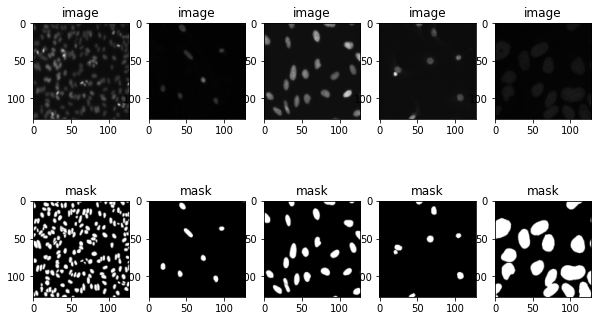

In [ ]:
# we will try visualizing images and corresponding masks
plot_img(5)

### UNET MODEL

In [ ]:
def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True)
    )

class Unet(nn.Module):
    def __init__(self):
        super().__init__()
        self.dblock1 = double_conv(3, 64)
        self.dblock2 = double_conv(64, 128)
        self.dblock3 = double_conv(128,256)
        self.dblock4 = double_conv(256,512)

        self.pool = nn.MaxPool2d(2)
        #self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True) 

        self.up_trans_1  = nn.ConvTranspose2d(in_channels= 512,out_channels= 256,kernel_size= 2,stride= 2)
        self.up_trans_2  = nn.ConvTranspose2d(in_channels= 256,out_channels= 128,kernel_size= 2,stride= 2)
        self.up_trans_3  = nn.ConvTranspose2d(in_channels= 128,out_channels= 64,kernel_size= 2,stride= 2)

        self.dblock5 = double_conv(256 + 256, 256)
        self.dblock6 = double_conv(128 + 128, 128)
        self.dblock7 = double_conv(64 + 64, 64)

        self.last_layer = nn.Conv2d(64,1,1)
        self.sigmoid = nn.Sigmoid()

    def forward(self,x):
        #decoder
        conv1 = self.dblock1(x)           #3  #64x128x128
        x = self.pool(conv1)                  #64x64x64

        conv2 = self.dblock2(x)           #2  #128x64x64
        x = self.pool(conv2)                  #128xx32x32

        conv3 = self.dblock3(x)           #1  #256x32x32
        x = self.pool(conv3)                  #256x16x16

        conv4 = self.dblock4(x)               #512x16x16
        
        #encoder
        x = self.up_trans_1(conv4)            #256x32x32
        x = torch.cat([x,conv3], dim=1)  #1   #(256+256)x32x32
        x = self.dblock5(x)                   #256x32x32

        x = self.up_trans_2(x)                #128x64x64
        x = torch.cat([x,conv2], dim=1)   #2  #(128+128)x64x64
        x = self.dblock6(x)                   #128x64x64

        x = self.up_trans_3(x)                #64x128x128
        x = torch.cat([x,conv1], dim=1)  #3   #(64+64)x128x128
        x = self.dblock7(x)                   #64x128x128

        out = self.last_layer(x)
        #out = self.sigmoid(x)

        return out


In [ ]:
model = Unet().to(device)
summary(model, (3,128,128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           1,792
              ReLU-2         [-1, 64, 128, 128]               0
            Conv2d-3         [-1, 64, 128, 128]          36,928
              ReLU-4         [-1, 64, 128, 128]               0
         MaxPool2d-5           [-1, 64, 64, 64]               0
            Conv2d-6          [-1, 128, 64, 64]          73,856
              ReLU-7          [-1, 128, 64, 64]               0
            Conv2d-8          [-1, 128, 64, 64]         147,584
              ReLU-9          [-1, 128, 64, 64]               0
        MaxPool2d-10          [-1, 128, 32, 32]               0
           Conv2d-11          [-1, 256, 32, 32]         295,168
             ReLU-12          [-1, 256, 32, 32]               0
           Conv2d-13          [-1, 256, 32, 32]         590,080
             ReLU-14          [-1, 256,

### LOSS + IOU METRICS

In [ ]:
#https://www.kaggle.com/bigironsphere/loss-function-library-keras-pytorch
class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)       
        bce_weight = 0.5
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        loss_final = BCE * bce_weight + dice_loss * (1 - bce_weight)
        return loss_final
    
## IOU computation
def iou_(y_pred,y):
    inputs = y_pred.reshape(-1)
    targets = y.reshape(-1)
    intersection = (inputs * targets).sum()
    total = (inputs + targets).sum()
    union = total - intersection 
    smooth = 1    
    iou = (intersection + smooth)/(union + smooth)
    return iou



def iou_batch(y_pred,y):
    '''computes mean iou for a batch of ground truth masks and predicted masks'''
    ious = []
    y_pred = F.sigmoid(y_pred)
    y_pred = y_pred.clone().cpu().detach().numpy()
    y = y.clone().cpu().detach().numpy() 
    
    for pred, label in zip(y_pred, y):
        ious.append(iou_(pred, label))
    iou = np.nanmean(ious)
    return iou

### CHECKPOINT UTILITY FUNCTION

In [ ]:
#https://towardsdatascience.com/how-to-save-and-load-a-model-in-pytorch-with-a-complete-example-c2920e617dee
def save_ckp(state, is_best, checkpoint_path, best_model_path):
    """
    state: checkpoint we want to save
    is_best: is this the best checkpoint; min validation loss
    checkpoint_path: path to save checkpoint
    best_model_path: path to save best model
    """
    # save checkpoint data to the path given, checkpoint_path
    torch.save(state, checkpoint_path)
    # if it is a best model, min validation loss
    if is_best:
        # copy that checkpoint file to best path given, best_model_path
        shutil.copyfile(checkpoint_path, best_model_path)
        
def load_ckp(checkpoint_fpath, model, optimizer):
    """
    checkpoint_path: path to save checkpoint
    model: model that we want to load checkpoint parameters into       
    optimizer: optimizer we defined in previous training
    """
    # load check point
    checkpoint = torch.load(checkpoint_fpath)
    # initialize state_dict from checkpoint to model
    model.load_state_dict(checkpoint['state_dict'])
    # initialize optimizer from checkpoint to optimizer
    optimizer.load_state_dict(checkpoint['optimizer'])
    # initialize valid_loss_min from checkpoint to valid_loss_min
    valid_loss_min = checkpoint['valid_loss_min']
    # return model, optimizer, epoch value, min validation loss 
    return model, optimizer, checkpoint['epoch'], valid_loss_min.item()

In [ ]:
!pwd

/content


### TRAINING 50 EPOCHS

In [ ]:
#https://discuss.pytorch.org/t/how-are-optimizer-step-and-loss-backward-related/7350/6
checkpoint_path = '/content/data/chkpoint2_'
best_model_path = '/content/data/bestmodel2.pt'
epochs = 50
criterion = DiceBCELoss()
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
valid_loss_min = 3.95275 #org np.Inf //


train_loss,val_loss = [],[]
train_iou,val_iou = [],[]

for epoch in range(epochs):
    print('Epoch {}/{}'.format(epoch + 1, epochs))
    start_time = time.time()
     

    
    running_train_loss = []
    running_train_score = []
    #tk0 = tqdm(train_loader, total=int(len(train_loader)))
    for image,mask in train_loader: 
            image = image.to(device,dtype=torch.float)
            mask = mask.to(device,dtype=torch.float)
            
            pred_mask = model.forward(image) # forward propogation
            loss = criterion(pred_mask,mask)
            score = iou_batch(pred_mask,mask)
            optimizer.zero_grad() # setting gradient to zero
            loss.backward()
            optimizer.step()
            running_train_loss.append(loss.item())
            running_train_score.append(score)
    else:           
        running_val_loss = []
        running_val_score = []
        with torch.no_grad():
            for image,mask in val_loader:
                    image = image.to(device,dtype=torch.float)
                    mask = mask.to(device,dtype=torch.float)                            
                    pred_mask = model.forward(image)
                    loss = criterion(pred_mask,mask)
                    score = iou_batch(pred_mask,mask)
                    running_val_loss.append(loss.item())
                    running_val_score.append(score)

    epoch_train_loss,epoch_train_score = np.mean(running_train_loss) ,np.mean(running_train_score)
    print('Train loss : {} iou : {}'.format(epoch_train_loss,epoch_train_score))                       
    train_loss.append(epoch_train_loss)
    train_iou.append(epoch_train_score)
    
    epoch_val_loss,epoch_val_score = np.mean(running_val_loss),np.mean(running_val_score)
    print('Validation loss : {} iou : {}'.format(epoch_val_loss,epoch_val_score))                                
    val_loss.append(epoch_val_loss)
    val_iou.append(epoch_val_score)
    
    #create checkpoint variable and add important data
    checkpoint = {
            'epoch': epoch + 1,
            'valid_loss_min': epoch_val_loss,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
        }
    
    # save checkpoint
    save_ckp(checkpoint, False, checkpoint_path, best_model_path)
    #https://towardsdatascience.com/how-to-save-and-load-a-model-in-pytorch-with-a-complete-example-c2920e617dee
    if epoch_val_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,epoch_val_loss))
            # save checkpoint as best model
            save_ckp(checkpoint, True, checkpoint_path, best_model_path)
            valid_loss_min = epoch_val_loss
    
    time_elapsed = time.time() - start_time
    print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

Epoch 1/50


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1625: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train loss : 0.5341798056816233 iou : 0.15820841215732045
Validation loss : 0.44819502035776776 iou : 0.2220760169328013
Validation loss decreased (3.952750 --> 0.448195).  Saving model ...
8m 11s
Epoch 2/50
Train loss : 0.4294259548187256 iou : 0.27137797107220796
Validation loss : 0.5642305910587311 iou : 0.2872188213368768
7m 52s
Epoch 3/50
Train loss : 0.36016220933404464 iou : 0.4090997667832604
Validation loss : 0.33313997089862823 iou : 0.4602853721905695
Validation loss decreased (0.448195 --> 0.333140).  Saving model ...
8m 9s
Epoch 4/50
Train loss : 0.3248140025755455 iou : 0.4335256887966742
Validation loss : 0.22099805043803322 iou : 0.5446089298137976
Validation loss decreased (0.333140 --> 0.220998).  Saving model ...
8m 10s
Epoch 5/50
Train loss : 0.34121500597945575 iou : 0.4535314918041716
Validation loss : 0.34045618772506714 iou : 0.4061561044516346
8m 3s
Epoch 6/50
Train loss : 0.27012650848462666 iou : 0.5032749678983742
Validation loss : 0.22682814796765646 iou : 

### VISUALIZING SOME IMAGES FROM TRAINED MODEL

In [ ]:
#loading the saved model
model, optimizer, start_epoch, valid_loss_min = load_ckp(checkpoint_path, model, optimizer)

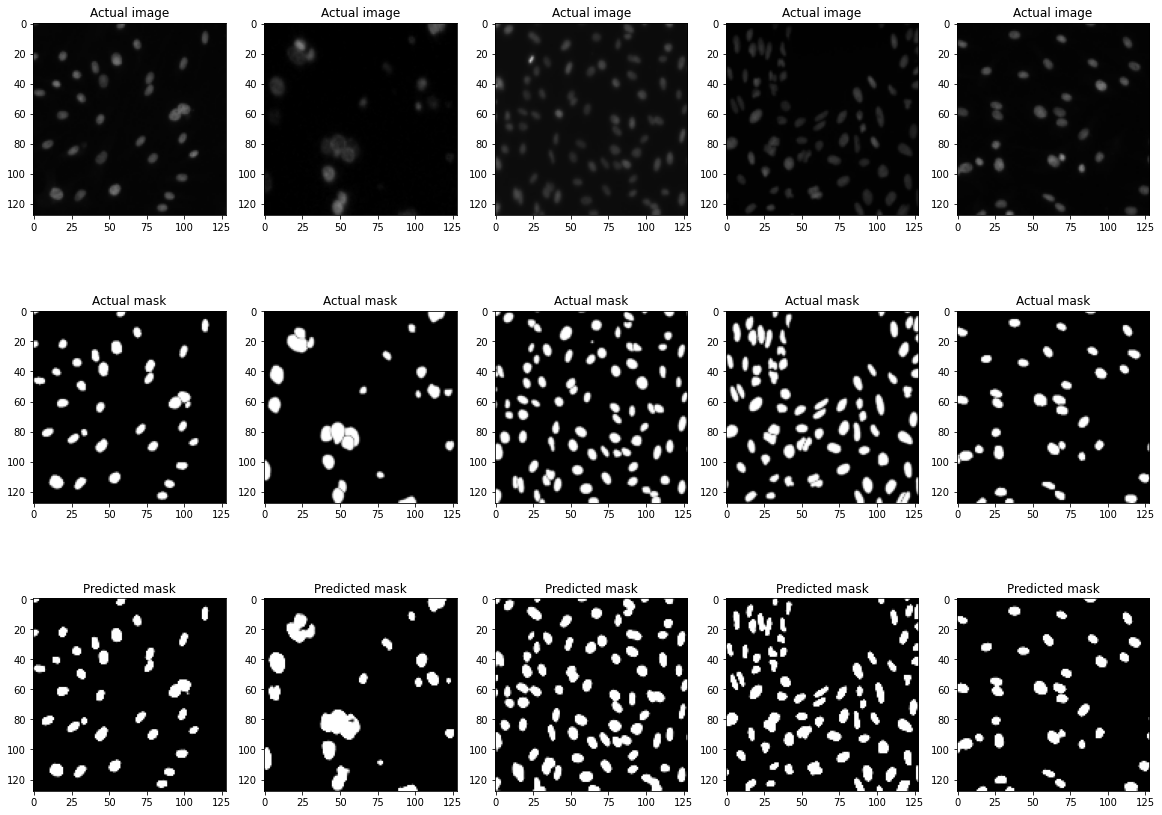

In [ ]:
iter_ = iter(val_loader)
image,mask = next(iter_)
image = image.to(device,dtype=torch.float)
mask = mask.to(device,dtype=torch.float)
y_pred = model.forward(image)


plt.figure(figsize=(20,15))
for i in range(0,5):
    plt.subplot(3,5,i+1)
    plt.title('Actual image')
    plt.imshow(image_convert(image[i]))
for i in range(0,5):
    plt.subplot(3,5,i+5+1)
    plt.title('Actual mask')
    plt.imshow(mask_convert(mask[i]),cmap='gray')
for i in range(0,5):
    plt.subplot(3,5,i+10+1)
    plt.title('Predicted mask')
    plt.imshow(mask_convert(y_pred[i]),cmap='gray')
plt.show()

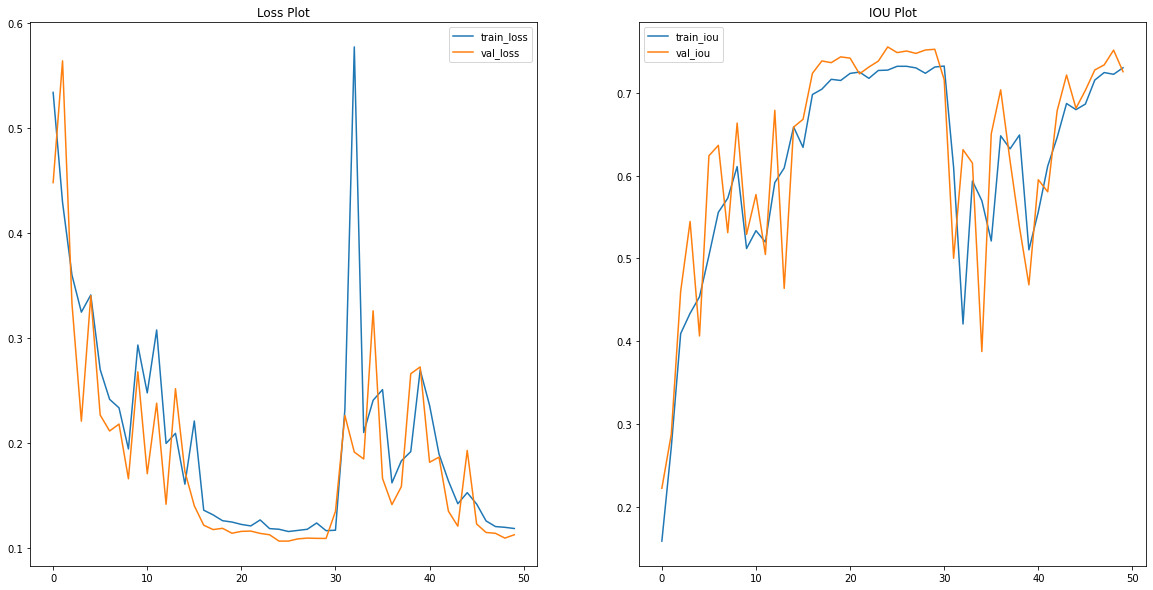

In [ ]:
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.plot(train_loss,label='train_loss')
plt.plot(val_loss,label='val_loss')
plt.legend()
plt.title('Loss Plot')
plt.subplot(1,2,2)
plt.plot(train_iou,label='train_iou')
plt.plot(val_iou,label='val_iou')
plt.legend()
plt.title('IOU Plot')
plt.show()

In [1]:
# WORK IN PROGRESS